<a href="https://colab.research.google.com/github/ChiriKamau/notebooks/blob/main/anyshape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

lets see

### Imports and Scale Calibration

This cell imports the required Python libraries for image processing and visualization.  
OpenCV (`cv2`) is used for computer vision operations, NumPy for numerical computation, and Matplotlib for displaying images.

A real-world scale is defined based on a known reference measurement in the image:
- **10 cm corresponds to 535 pixels**

From this reference, a pixel-to-centimeter conversion factor is computed.  
This conversion factor is later used to transform pixel-based measurements into real-world physical units (cm and cm²).


In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [37]:

# Known scale: 10 cm = 535 pixels
PIXELS_PER_10CM = 535
CM_PER_PIXEL = 10.0 / PIXELS_PER_10CM
CM2_PER_PIXEL2 = CM_PER_PIXEL ** 2

print(f"Scale: 1 pixel = {CM_PER_PIXEL:.6f} cm")


Scale: 1 pixel = 0.018692 cm


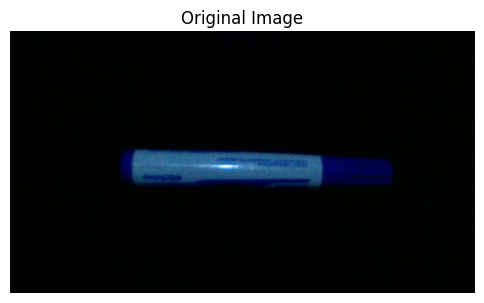

In [38]:
# Load image
import requests # Import the requests library

image_url = "https://raw.githubusercontent.com/ChiriKamau/notebooks/main/pen.jpg"

# Use requests to get the image from the URL
response = requests.get(image_url)
# Convert the response content to a numpy array
image_array = np.array(bytearray(response.content), dtype=np.uint8)
# Decode the image array using OpenCV
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

### Image Preprocessing

The image is converted to grayscale because most segmentation and edge detection algorithms operate on single-channel intensity images rather than color images.

A Gaussian blur is applied to suppress high-frequency noise and small intensity variations.  
This step improves segmentation stability and reduces boundary irregularities, leading to more accurate area measurements.


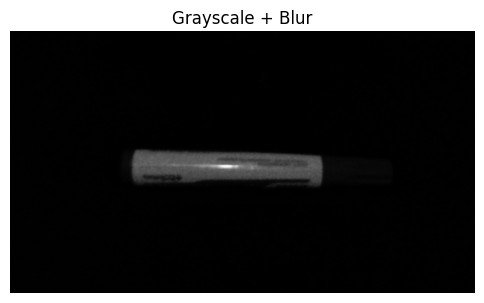

In [39]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Reduce noise (important for accuracy)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

plt.figure(figsize=(6,6))
plt.imshow(blur, cmap="gray")
plt.title("Grayscale + Blur")
plt.axis("off")
plt.show()


### Binary Segmentation

Automatic thresholding using Otsu’s method is applied to separate the object of interest from the background.

Otsu’s algorithm computes an optimal threshold by minimizing intra-class intensity variance, making it robust to lighting variations.

The binary mask is inspected and inverted if necessary to ensure that the object appears in white and the background in black.


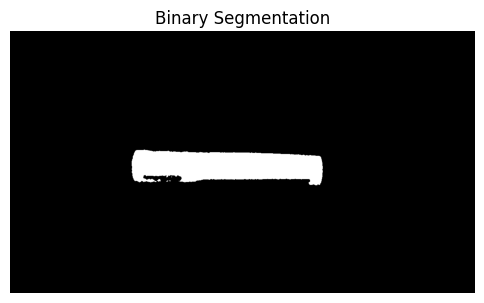

In [40]:
# Automatic threshold (Otsu)
_, segmentation = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Ensure object is white
if np.mean(segmentation) > 127:
    segmentation = cv2.bitwise_not(segmentation)

plt.figure(figsize=(6,6))
plt.imshow(segmentation, cmap="gray")
plt.title("Binary Segmentation")
plt.axis("off")
plt.show()


### Morphological Cleaning

Morphological operations are applied to improve the quality of the binary segmentation.

- **Closing** fills small holes inside the object.
- **Opening** removes isolated noise pixels and small artifacts.

These operations produce smoother object boundaries, which is critical for accurate contour extraction and area calculation.


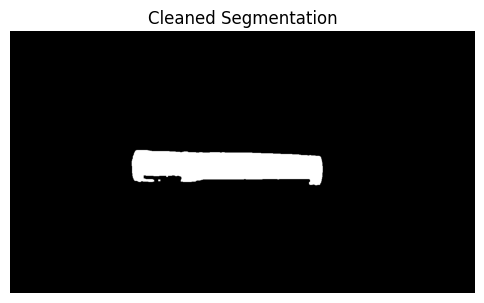

In [41]:
kernel = np.ones((5,5), np.uint8)

segmentation = cv2.morphologyEx(segmentation, cv2.MORPH_CLOSE, kernel)
segmentation = cv2.morphologyEx(segmentation, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(6,6))
plt.imshow(segmentation, cmap="gray")
plt.title("Cleaned Segmentation")
plt.axis("off")
plt.show()


### Contour Extraction

Contours are extracted from the cleaned binary image.  
Only external contours are retrieved, and the contour with the largest area is assumed to correspond to the target object.

The contour is stored with full point resolution to preserve geometric accuracy during measurement.


In [42]:
contours, _ = cv2.findContours(
    segmentation,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_NONE   # best accuracy
)

largest_contour = max(contours, key=cv2.contourArea)

print(f"Detected contours: {len(contours)}")


Detected contours: 2


### Area Measurement (Contour-Based)

The object area is computed using the contour geometry rather than pixel counting.

Contour-based area measurement provides sub-pixel accuracy and reduces quantization errors introduced by binary pixel grids.

The measured area in pixel units is converted to square centimeters using the previously defined scale factor.


### Area Calculation Method

The object area is calculated using a contour-based geometric approach rather than direct pixel counting.

After segmentation, the object is represented as a binary image where the object appears in white and the background appears in black. From this binary mask, the boundary of the object is extracted as a closed contour consisting of ordered coordinate points:

(x1, y1), (x2, y2), ..., (xn, yn)

The area enclosed by this contour is computed using a polygon area formula (shoelace formula), defined as:

A_pixels = 1/2 × | Σ ( xi × y(i+1) − x(i+1) × yi ) |

where the index (i+1) wraps around so that the last point connects back to the first point.

OpenCV’s `cv2.contourArea()` function applies this formula internally to compute the object area with sub-pixel accuracy.

To convert the area from pixel units to real-world units, a scale calibration is applied. Given that:

10 cm = 535 pixels

the conversion factors are:

1 pixel = 10 / 535 cm  
1 pixel² = (10 / 535)² cm²  

The final physical area is therefore calculated as:

A_cm² = A_pixels × (10 / 535)²

This contour-based method is independent of object shape and provides higher accuracy than pixel-counting methods, particularly along curved or irregular boundaries.


In [43]:
# Sub-pixel contour area
area_pixels = cv2.contourArea(largest_contour)
area_cm2 = area_pixels * CM2_PER_PIXEL2

print(f"Area: {area_pixels:.2f} pixels²")
print(f"Area: {area_cm2:.4f} cm²")


Area: 37849.50 pixels²
Area: 13.2237 cm²


### Additional Geometric Measurements

This cell computes additional geometric properties that are independent of object shape:

- **Perimeter**: calculated from the contour length
- **Bounding box**: provides an estimate of object width and height

These measurements are useful for shape analysis, size estimation, and validation of segmentation quality.


In [44]:
# Perimeter
perimeter_pixels = cv2.arcLength(largest_contour, True)
perimeter_cm = perimeter_pixels * CM_PER_PIXEL

# Bounding box
x, y, w, h = cv2.boundingRect(largest_contour)
width_cm = w * CM_PER_PIXEL
height_cm = h * CM_PER_PIXEL

print(f"Perimeter: {perimeter_cm:.2f} cm")
print(f"Bounding width: {width_cm:.2f} cm")
print(f"Bounding height: {height_cm:.2f} cm")


Perimeter: 24.81 cm
Bounding width: 9.83 cm
Bounding height: 1.81 cm


### Visualization of Measurement Results

The final cell overlays the detected contour and bounding box onto the original image.

This visual confirmation allows verification that the correct object was measured and that the segmentation aligns accurately with object boundaries.

Measured physical quantities are displayed in the figure title for clarity and documentation.


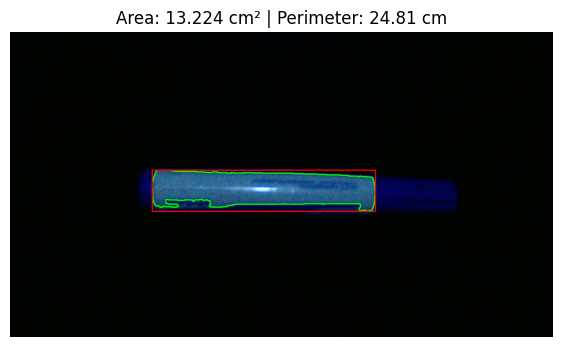

In [46]:
output = image_rgb.copy()

# Draw contour
cv2.drawContours(output, [largest_contour], -1, (0, 255, 0), 2)

# Draw bounding box
cv2.rectangle(output, (x, y), (x+w, y+h), (255, 0, 0), 2)

plt.figure(figsize=(7,7))
plt.imshow(output)
plt.title(
    f"Area: {area_cm2:.3f} cm² | Perimeter: {perimeter_cm:.2f} cm"
)
plt.axis("off")
plt.show()
